# TD5 - Flower Classification

Fabiano Junior Maia Manschein

IMLEX

References:
- https://www.tensorflow.org/tutorials/load_data/images

# Imports

In [1]:
import keras_tuner as kt
import numpy as np
import tensorflow as tf
import pathlib

import matplotlib.pyplot as plt
%matplotlib inline  


2023-03-27 17:08:07.145638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 17:08:08.772046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data

The dataset contains 800 RGB images of 10 different categories of flowers, with 600 of these images for the training set, and 200 for the validation set. We'll consider the flower categories as the classes, and the training and validation sets have 60 and 20 images per class, respectively.

In [2]:
base_path = "data/Flowers/"
data_dir = pathlib.Path(base_path)
image_count = len(list(data_dir.glob('*/*/*.jpg')))
print(f"Number of images: {image_count}")

Number of images: 800


## Training, validation and test datasets

Since the images are already separated into training and test sets, all we have to do is load them. We'll use a 80/20 split for training/validation.

Here, we load the data using two different methods: `image_dataset_from_directory()` and `ImageDataGenerator.flow_from_directory()`. I did this because I wanted to experiment with both methods of loading the data and, as far as I know, data augmentation is not possible with `image_dataset_from_directory()` and `flow_from_directory()` gives more flexibility.

It will also be interesting to evaluate the model trained on raw data versus trained on augmented data.

In [3]:
# Loader parameters
batch_size = 32
img_height = 128
img_width = 128
train_dir = pathlib.Path(base_path + "Train/")
test_dir = pathlib.Path(base_path + "Test/") 

print("Training and validation")
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  subset="both",
  validation_split=0.2,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

print("Test")
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Training and validation
Found 600 files belonging to 10 classes.
Using 480 files for training.
Using 120 files for validation.
Test


2023-03-27 17:08:11.485590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-03-27 17:08:11.559665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-03-27 17:08:11.559990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 200 files belonging to 10 classes.


Let's check the class names:

In [4]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(num_classes, class_names)

10 ['Fleurs0', 'Fleurs1', 'Fleurs2', 'Fleurs3', 'Fleurs4', 'Fleurs5', 'Fleurs6', 'Fleurs7', 'Fleurs8', 'Fleurs9']


## Visualize the data

Here are the first 9 images from the training dataset.

2023-03-27 17:08:12.695868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [480]
	 [[{{node Placeholder/_4}}]]
2023-03-27 17:08:12.696798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [480]
	 [[{{node Placeholder/_0}}]]


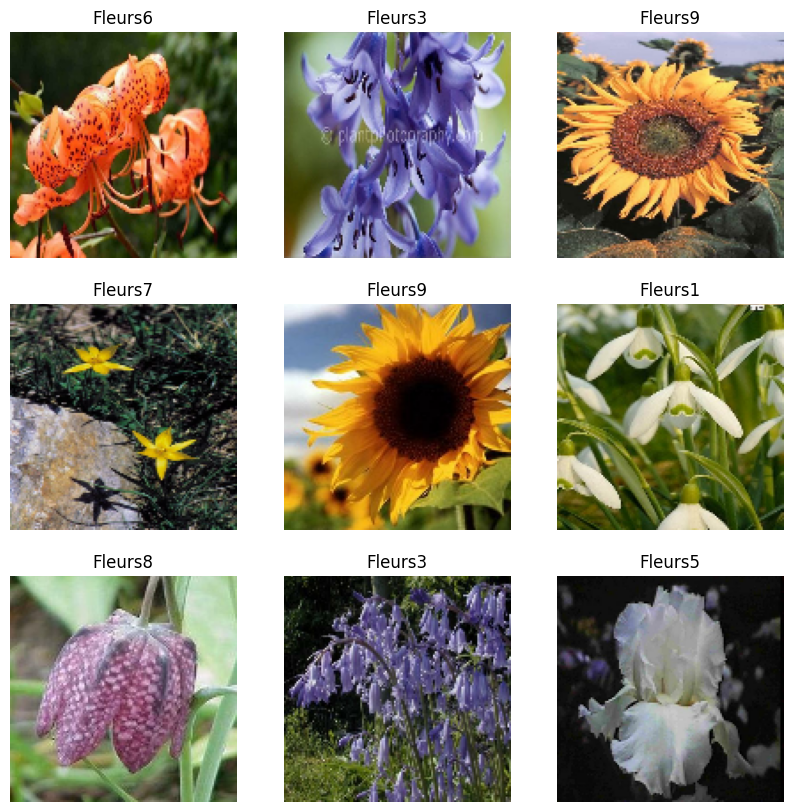

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Retrieve batches of images:

In [6]:
for image_batch, labels_batch in train_ds:
  print(f"Image shape = {image_batch.shape}, labels batch shape = {labels_batch.shape}")
  break

Image shape = (32, 128, 128, 3), labels batch shape = (32,)


2023-03-27 17:08:14.866764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [480]
	 [[{{node Placeholder/_4}}]]
2023-03-27 17:08:14.867372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [480]
	 [[{{node Placeholder/_4}}]]


The image_batch is a tensor of the shape `(32, 128, 128, 3)`. This is a batch of 32 images of shape `128x128x3` (the last dimension refers to color channels RGB). The `labels_batch` is a tensor of the shape `(32,)`, these are the corresponding labels to the 32 images.

## Standardize the data

The RGB channel values are in the `[0, 255]` range. Here, we will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

*Note*: `ImageDataGenerator` has a parameter for rescaling, which was used when loading the data.

In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods we should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training the model. If the dataset is too large to fit into memory, we can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Training a model from scratch

Our goal accuracy is:

In [9]:
goal_acc = 0.74

In this section, we'll build our own architecture step-by-step, and train it. Let's start with a very simple model.

In [10]:
model = tf.keras.Sequential([
  normalization_layer,
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

Let's train it for a small number of `epochs` to check its performance. This will be our base reference for improving it.

In [11]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5


2023-03-27 17:08:15.554732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [480]
	 [[{{node Placeholder/_4}}]]
2023-03-27 17:08:15.555424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [480]
	 [[{{node Placeholder/_0}}]]
2023-03-27 17:08:18.022868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-03-27 17:08:18.745557: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-27 17:08:18.843007: I tensorflow/compiler/xla/st

 7/15 [=============>................] - ETA: 0s - loss: 7.9015 - accuracy: 0.1429  

2023-03-27 17:08:20.006836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [120]
	 [[{{node Placeholder/_4}}]]
2023-03-27 17:08:20.007344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [120]
	 [[{{node Placeholder/_4}}]]


15/15 [==============================] - 5s 27ms/step - loss: 5.8088 - accuracy: 0.2167 - val_loss: 3.1944 - val_accuracy: 0.3000
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 1.5206 - accuracy: 0.4854 - val_loss: 1.5560 - val_accuracy: 0.4083
Epoch 3/5
15/15 [==============================] - 0s 9ms/step - loss: 0.8106 - accuracy: 0.7604 - val_loss: 1.1095 - val_accuracy: 0.6667
Epoch 4/5
15/15 [==============================] - 0s 9ms/step - loss: 0.4161 - accuracy: 0.9271 - val_loss: 0.9898 - val_accuracy: 0.6500
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.2121 - accuracy: 0.9708 - val_loss: 0.8454 - val_accuracy: 0.7417


In [12]:
score = model.evaluate(test_ds)

print(f'Test accuracy: {score[1]:.3f}')

7/7 [==============================] - 0s 10ms/step - loss: 1.3304 - accuracy: 0.5300
Test accuracy: 0.530


2023-03-27 17:08:20.902777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [200]
	 [[{{node Placeholder/_4}}]]
2023-03-27 17:08:20.903402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [200]
	 [[{{node Placeholder/_4}}]]


We can easily notice overfitting past the third `epoch`. This already indicates we might need dropout and data augmentation layers to counter overfitting and improve validation accuracy. Before that, let's make the model a bit more complex.

Reduce learning rate on plateau:

In [13]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

Early stopping when loss stops decreasing:

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

Number of epochs:

In [15]:
n_epochs = 100

Currently, the model has a single convolution layers, and a single max pooling layer. As such, the output is reduced to `63x63` from its original input `128x128`, meaning that the feature maps don't go much into the finer details of the images. This can be seen below, with the summary of the model.

Also, as we're using only 32 neurons in the convolution layer, we only have 32 feature maps. You typically want more features than categories. Let's first try increasing the number of feature maps a bit.

We also want to keep the output shape the same as the input for convolution layers. We'll adjust the padding to get this result.

In [16]:
model = tf.keras.Sequential([
  normalization_layer,
  tf.keras.layers.Conv2D(64, 5, activation='leaky_relu', strides=1, padding="same", input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(64, 3, activation='leaky_relu', padding="same"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='leaky_relu', padding="same"),
  tf.keras.layers.Conv2D(64, 3, activation='leaky_relu', padding="same"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation="leaky_relu"),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop]
)

score = model.evaluate(test_ds)
print(f'Test accuracy: {score[1]:.3f} \nImprovement: {(score[1] - goal_acc)*100:.2f}%')

Epoch 1/100
15/15 [==============================] - 5s 66ms/step - loss: 4658.8447 - accuracy: 0.1063 - val_loss: 972.3383 - val_accuracy: 0.1333 - lr: 0.0100
Epoch 2/100
15/15 [==============================] - 0s 25ms/step - loss: 2268.9141 - accuracy: 0.1458 - val_loss: 1239.4845 - val_accuracy: 0.0833 - lr: 0.0100
Epoch 3/100
15/15 [==============================] - 0s 25ms/step - loss: 1491.6261 - accuracy: 0.1187 - val_loss: 659.7142 - val_accuracy: 0.0917 - lr: 0.0100
Epoch 4/100
15/15 [==============================] - 0s 25ms/step - loss: 1227.2877 - accuracy: 0.1104 - val_loss: 820.8190 - val_accuracy: 0.1917 - lr: 0.0100
Epoch 5/100
15/15 [==============================] - 0s 26ms/step - loss: 956.7726 - accuracy: 0.1271 - val_loss: 947.4934 - val_accuracy: 0.1417 - lr: 0.0100
Epoch 6/100
15/15 [==============================] - 0s 26ms/step - loss: 467.2145 - accuracy: 0.1271 - val_loss: 165.1761 - val_accuracy: 0.0833 - lr: 0.0100
Epoch 7/100
15/15 [======================

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      4864      
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        36928     
                                                      

No significant improvements over the original simpler model. Let's try adding Batchnorms and Dropouts to avoid overfitting and improve accuracy.

## Batchnorms and Dropout

Let's try improving accuracy by applying batch normalization and dropout to our model. After some research, I found this paper that recommends to always add the Dropout layer after the BatchNorm to avoid variance shift. Let's try and apply that. 

Source: [Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)

In [18]:
model = tf.keras.Sequential([
  normalization_layer,
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same", input_shape=(img_height, img_width, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop]
)

score = model.evaluate(test_ds)
print(f'Test accuracy: {score[1]:.3f} \nImprovement: {(score[1] - goal_acc)*100:.2f}%')

Epoch 1/100
15/15 [==============================] - 4s 32ms/step - loss: 8.1164 - accuracy: 0.1875 - val_loss: 236.1644 - val_accuracy: 0.1583 - lr: 0.1000
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - loss: 3.1046 - accuracy: 0.3125 - val_loss: 48.7568 - val_accuracy: 0.1583 - lr: 0.1000
Epoch 3/100
15/15 [==============================] - 0s 14ms/step - loss: 2.0761 - accuracy: 0.3042 - val_loss: 8.5561 - val_accuracy: 0.2083 - lr: 0.1000
Epoch 4/100
15/15 [==============================] - 0s 15ms/step - loss: 1.7504 - accuracy: 0.3708 - val_loss: 6.4027 - val_accuracy: 0.1750 - lr: 0.1000
Epoch 5/100
15/15 [==============================] - 0s 14ms/step - loss: 1.5609 - accuracy: 0.4417 - val_loss: 3.6565 - val_accuracy: 0.2833 - lr: 0.1000
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - loss: 1.4507 - accuracy: 0.4854 - val_loss: 2.4433 - val_accuracy: 0.3333 - lr: 0.1000
Epoch 7/100
15/15 [==============================] - 0s 13ms/step -

# Data augmentation

Let's try augmenting the dataset to improve training.

In [19]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomBrightness(0.2),
  tf.keras.layers.RandomTranslation(0.2, 0.2),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

Let's check some of the augmented images.

2023-03-27 17:09:29.850669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [480]
	 [[{{node Placeholder/_0}}]]
2023-03-27 17:09:29.851104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [480]
	 [[{{node Placeholder/_0}}]]


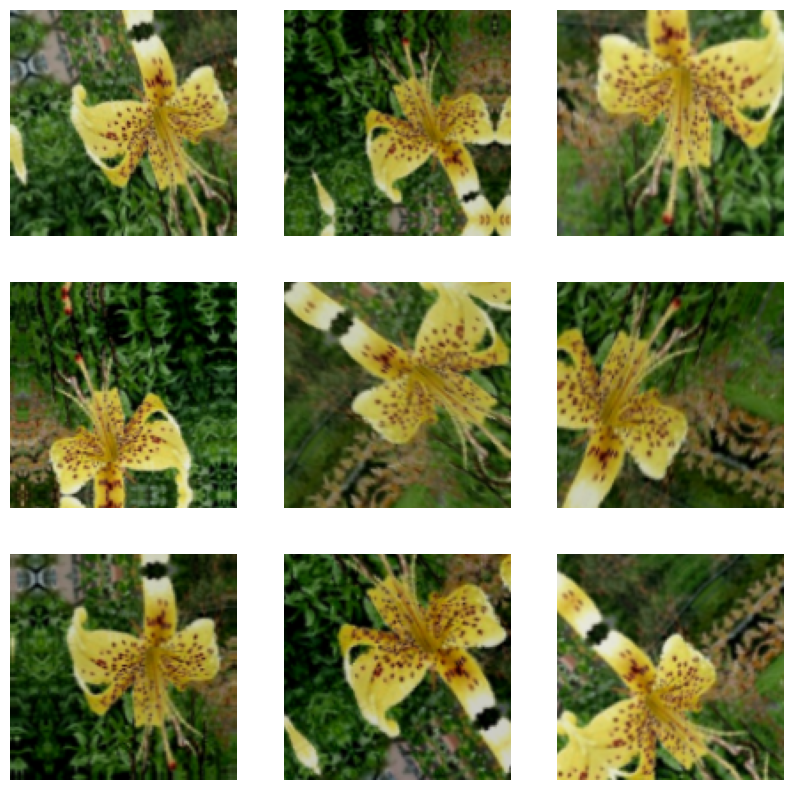

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [21]:
model = tf.keras.Sequential([
  data_augmentation,
  normalization_layer,
  tf.keras.layers.Conv2D(32, 5, strides=1, padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),

  tf.keras.layers.Conv2D(32, 3, strides=1, padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(64, 3, padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),

  tf.keras.layers.Conv2D(64, 3, padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(128, 3, padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),

  tf.keras.layers.Conv2D(128, 3, padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(256, 3, padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),

  tf.keras.layers.Conv2D(256, 3, padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(512),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),

  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=
[reduce_lr, early_stop]
)

score = model.evaluate(test_ds)
print(f'Test accuracy: {score[1]:.3f} \nImprovement: {(score[1] - goal_acc)*100:.2f}%')

Epoch 1/100
15/15 [==============================] - 11s 104ms/step - loss: 2.7670 - accuracy: 0.2146 - val_loss: 8674.1074 - val_accuracy: 0.0917 - lr: 0.0100
Epoch 2/100
15/15 [==============================] - 0s 33ms/step - loss: 2.0727 - accuracy: 0.3292 - val_loss: 1132.5682 - val_accuracy: 0.2583 - lr: 0.0100
Epoch 3/100
15/15 [==============================] - 0s 33ms/step - loss: 1.8066 - accuracy: 0.3375 - val_loss: 170.8169 - val_accuracy: 0.2417 - lr: 0.0100
Epoch 4/100
15/15 [==============================] - 0s 33ms/step - loss: 1.5726 - accuracy: 0.4521 - val_loss: 59.5344 - val_accuracy: 0.2083 - lr: 0.0100
Epoch 5/100
15/15 [==============================] - 0s 31ms/step - loss: 1.7051 - accuracy: 0.4313 - val_loss: 136.8914 - val_accuracy: 0.1583 - lr: 0.0100
Epoch 6/100
15/15 [==============================] - 0s 32ms/step - loss: 1.6299 - accuracy: 0.4604 - val_loss: 11.8285 - val_accuracy: 0.2000 - lr: 0.0100
Epoch 7/100
15/15 [==============================] - 0s 

In [22]:
model.save('models/other')

2023-03-27 17:10:22.621348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [?,128,128,3]
	 [[{{node random_flip_input}}]]
2023-03-27 17:10:22.982033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128,128,3]
	 [[{{node inputs}}]]
2023-03-27 17:10:23.021099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [

INFO:tensorflow:Assets written to: models/other/assets


INFO:tensorflow:Assets written to: models/other/assets


## Tuning model hyperparameters

https://keras.io/guides/keras_tuner/getting_started/

For tuning the model hyperparameters, we'll use the Keras tuner. First, we define a function to build the model:

In [35]:
def build_model(hp):
  filter_mult = hp.Choice('filter_mult', [1, 2])
  kernel_size = hp.Choice('kernel_size', [3, 5])
  strides = hp.Choice('strides', [1, 2])
  dropout_rate = hp.Choice('dropout_rate', [0.25, 0.5, 0.75])
  neurons = hp.Choice('neurons', [256, 512])

  filters1 = 32*filter_mult
  filters2 = 64*filter_mult
  filters3 = 128*filter_mult
  filters4 = 256*filter_mult

  model = tf.keras.Sequential([
    data_augmentation,
    normalization_layer,
    tf.keras.layers.Conv2D(filters=filters1, kernel_size=kernel_size, strides=strides, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(filters=filters1, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(filters=filters2, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(filters=filters2, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(filters=filters3, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(filters=filters3, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(filters=filters4, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(filters=filters4, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(neurons),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Dropout(dropout_rate),

    tf.keras.layers.Dense(num_classes, activation="softmax")
  ])

  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
  
  return model

Initialize the tuner:

In [36]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    max_trials=5,
    objective='val_accuracy',
    directory="tuner",
    overwrite=True,
    project_name="flower-clf")

tuner.search_space_summary()

Search space summary
Default search space size: 5
filter_mult (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
strides (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
dropout_rate (Choice)
{'default': 0.25, 'conditions': [], 'values': [0.25, 0.5, 0.75], 'ordered': True}
neurons (Choice)
{'default': 256, 'conditions': [], 'values': [256, 512], 'ordered': True}


Start the search:

In [38]:
tuner.search(train_ds, epochs=100, validation_data=val_ds, verbose=2, callbacks=[reduce_lr, early_stop])

Trial 5 Complete [00h 01m 07s]
val_accuracy: 0.25833332538604736

Best val_accuracy So Far: 0.2750000059604645
Total elapsed time: 00h 06m 04s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


**Unfortunately**, it seems the tuner crashes before it's able to complete all trials: `INFO:tensorflow:Oracle triggered exit`

Summary of results:

In [39]:
tuner.results_summary()

Results summary
Results in tuner/flower-clf
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
filter_mult: 1
kernel_size: 5
strides: 1
dropout_rate: 0.75
neurons: 256
Score: 0.2750000059604645

Trial 4 summary
Hyperparameters:
filter_mult: 2
kernel_size: 5
strides: 1
dropout_rate: 0.75
neurons: 512
Score: 0.25833332538604736

Trial 2 summary
Hyperparameters:
filter_mult: 1
kernel_size: 5
strides: 2
dropout_rate: 0.75
neurons: 512
Score: 0.24166665971279144

Trial 3 summary
Hyperparameters:
filter_mult: 2
kernel_size: 3
strides: 1
dropout_rate: 0.25
neurons: 512
Score: 0.17499999701976776

Trial 1 summary
Hyperparameters:
filter_mult: 1
kernel_size: 5
strides: 1
dropout_rate: 0.5
neurons: 512
Score: 0.13333334028720856


And the best model:

In [46]:
best_models = tuner.get_best_models(num_models=5)
best_models[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                        

Evaluate the best models on the test dataset:

In [48]:
for i in range(len(best_models)):
    score = best_models[i].evaluate(test_ds, verbose=0)
    print(f'({i}) Test accuracy: {score[1]:.3f} | Improvement: {(score[1] - goal_acc)*100:.2f}%')

(0) Test accuracy: 0.255 | Improvement: -48.50%
(1) Test accuracy: 0.265 | Improvement: -47.50%
(2) Test accuracy: 0.180 | Improvement: -56.00%
(3) Test accuracy: 0.180 | Improvement: -56.00%
(4) Test accuracy: 0.170 | Improvement: -57.00%


As the tuner crashed, we didn't go through the entire search space to find the optimal hyperparameter values, resulting in poor performance.

# Pre-trained model

For this section, we'll use transfer learning with the VGG19 model pre-trained on ImageNet.

Source: https://keras.io/guides/transfer_learning/#the-typical-transferlearning-workflow

In [91]:
base_model = tf.keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_width, img_height, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

80134624/80134624 [==============================] - 1s 0us/step


We loaded the model with weights pre-trained on ImageNet. Now, we freeze the model, except the last layer.

In [92]:
base_model.trainable = False

And create a new model on top of it.

In [93]:
# Create the model
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

Now we train the model.

In [94]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

model.fit(train_ds, epochs=100, callbacks=[early_stop, reduce_lr], validation_data=val_ds)

Epoch 1/100
15/15 [==============================] - 2s 45ms/step - loss: 17.9676 - accuracy: 0.3375 - val_loss: 3.5357 - val_accuracy: 0.7167 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - 0s 28ms/step - loss: 3.8589 - accuracy: 0.7833 - val_loss: 3.3536 - val_accuracy: 0.7833 - lr: 0.0010
Epoch 3/100
15/15 [==============================] - 0s 28ms/step - loss: 1.2701 - accuracy: 0.8958 - val_loss: 2.4219 - val_accuracy: 0.8417 - lr: 0.0010
Epoch 4/100
15/15 [==============================] - 0s 27ms/step - loss: 1.3134 - accuracy: 0.9229 - val_loss: 2.2832 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 5/100
15/15 [==============================] - 0s 27ms/step - loss: 0.4325 - accuracy: 0.9479 - val_loss: 2.8536 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 6/100
15/15 [==============================] - 0s 28ms/step - loss: 0.4174 - accuracy: 0.9521 - val_loss: 1.8482 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 7/100
15/15 [==============================] - 0s 27ms/step - l

In [95]:
score = model.evaluate(test_ds)
print(f'Test accuracy: {score[1]:.3f} \nImprovement: {(score[1] - goal_acc)*100:.2f}%')

7/7 [==============================] - 0s 20ms/step - loss: 6.7407 - accuracy: 0.6700
Test accuracy: 0.670 
Improvement: -7.00%


## Fine tuning

After the first training, we fine tune the model with a very low learning rate to try and avoid overfitting. Since the original model is huge (ImageNet), and our current dataset is very small, this step can quickly lead to overfitting and giving too large weight updates. This is why we use a very small value for the learning rate in this step.

In [96]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Very low learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(train_ds, epochs=100, callbacks=[reduce_lr, early_stop], validation_data=val_ds)

# Evaluate
score = model.evaluate(test_ds)
print(f'Test accuracy: {score[1]:.3f} \nImprovement: {(score[1] - goal_acc)*100:.2f}%')

Epoch 1/100
15/15 [==============================] - 8s 80ms/step - loss: 0.1324 - accuracy: 0.9854 - val_loss: 2.4567 - val_accuracy: 0.8417 - lr: 1.0000e-05
Epoch 2/100
15/15 [==============================] - 1s 57ms/step - loss: 0.1750 - accuracy: 0.9833 - val_loss: 2.9920 - val_accuracy: 0.8333 - lr: 1.0000e-05
Epoch 3/100
15/15 [==============================] - 1s 58ms/step - loss: 0.1268 - accuracy: 0.9833 - val_loss: 2.4989 - val_accuracy: 0.8417 - lr: 1.0000e-05
Epoch 4/100
15/15 [==============================] - 1s 56ms/step - loss: 0.1237 - accuracy: 0.9812 - val_loss: 2.3730 - val_accuracy: 0.8417 - lr: 1.0000e-05
Epoch 5/100
15/15 [==============================] - 1s 56ms/step - loss: 0.0083 - accuracy: 0.9958 - val_loss: 2.3139 - val_accuracy: 0.8583 - lr: 1.0000e-05
Epoch 6/100
15/15 [==============================] - 1s 56ms/step - loss: 0.0344 - accuracy: 0.9917 - val_loss: 2.0538 - val_accuracy: 0.8417 - lr: 1.0000e-05
Epoch 7/100
15/15 [===========================